<a href="https://colab.research.google.com/github/abhigyan13/Continual_Engine_Assignment/blob/main/Abhigyan_18JE0013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable

import os
import argparse

import os
import time
from google.colab.patches import cv2_imshow
import pickle
import cv2
import numpy as np
import glob
import urllib
from urllib.request import URLopener
from skimage.transform import rotate


from PIL import Image
import shutil

dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available()==False:
  dtype=torch.FloatTensor
from matplotlib import pyplot as plt

Extract category and URLs from VIS10CAT file

In [3]:
file_location='vis10cat.txt'   #specify Location of dataset
dataset=open(file_location,'r')
lines=dataset.readlines()
cat = [] 
link = []

for line in lines:
  x=line.split("\t")
  cat.append(x[0])
  link.append(x[1])



a) Data Cleaning

Missing and invalid url's are not not saved

In [ ]:
for i , l in enumerate(link):

  try:
    urllib.request.urlretrieve( l, "/content/drive/MyDrive/project_Abhigyan/image/img-{id}-{category}".format(id = i , category = cat[i] ) )

  except OSError as e:
    print(str(e) , 'at index ' , i , ' link = ' , link[i] )
    continue



In [ ]:
class MyOpener(URLopener):
   version = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; it; rv:1.8.1.11) Gecko/20071127 Firefox/2.0.0.11'
   
myopener = MyOpener()
print(len(link))
for i in range(len(link)):
  
  ind = link[i].rfind('.')
  linkt = link[i][:ind+1] + link[i][ind+1:ind+4]
  if linkt[-3:].lower() == "pdf":
    continue
  print(linkt)
  try:
    myopener.retrieve( linkt, "/content/drive/MyDrive/project_Abhigyan/image/img-{}".format(i) )

  except OSError as e:
    print(str(e),' -  at index  ' , i , ' link = ' , linkt )


In [ ]:
########### Removing Unopened Error images

impath = glob.glob("/content/drive/MyDrive/project_Abhigyan/image/*")
print(len(impath))

for path in impath:
  x = int( path.split("-")[-1] )
  try:
    img = Image.open(path)
  except:
    print("Removing index " , x)
    os.remove(path)
  
print('Final Count = ' , len(impath))

TRAINING SET STATISTICS

In [107]:
impath = glob.glob("/content/drive/MyDrive/project_Abhigyan/image/*")
count = {}
cate = []

for category in set(cat):
  count[category] = 0
  cate.append(category)

for path in impath:
  x =  path.split("-")[-1].split(".")[0]
  
  count[x] = count[x] + 1


for key in count.keys():
  print("count of " , key , " = " , count[key])

cate.sort()
label_to_id = {}
for i , categ in enumerate(cate):
  label_to_id[categ] = i

print('No. of training data' , len(impath))

count of  BarGraph  =  111
count of  Map  =  178
count of  AreaGraph  =  83
count of  RadarPlot  =  76
count of  PieChart  =  91
count of  VennDiagram  =  62
count of  LineGraph  =  96
count of  ParetoChart  =  91
count of  Table  =  113
count of  ScatterGraph  =  99
No. of training data 1000


Segregate some images for test

In [83]:
random.shuffle(impath)
for i , path in enumerate(impath):
  if i>=150:
    break
  nme = path.split("/")[-1]
  indd = path.rfind("/")
  new_path = path[:indd]+"2/" +nme
  shutil.move(path,new_path) 


 AUGMENTATION

 As the dataset is tiny , augument with flips rotations randomly

In [85]:
from skimage import io
from skimage import img_as_ubyte
import random

######## horizontal flip
def hflip(image):
  return np.fliplr(image)

######## right rotation

def right_rot(image):
  return rotate(image ,  -90 )

######## left rotation

def left_rot(image):
  return rotate(image , 90)

transformations = { "horizontal-flip": hflip , "right-90-rotation": right_rot , "left-90-rotation": left_rot }  #dictionary to store the transormations






impath = glob.glob("/content/drive/MyDrive/project_Abhigyan/image/*")

y = len(impath)
total = len(impath)

image_gen = 5  #set to how many more images needed


while y< total+image_gen:
  index = random.randint(1,total) - 1  #randomly generate an image to augment
  img_path = impath[index]
  category = img_path.split("-")[-1].split(".")[0]
  
  
  img = io.imread(img_path)
  key = random.choice(list(transformations))
  transformed_image = transformations[key](img) #randomly choose a tranformation from the above transformations

  new_img_path = "/content/drive/MyDrive/project_Abhigyan/image/img-{id}-{categ}.jpg".format(id = y , categ = category  )
  print("Saving Augumented image of " ,category ,   " at " , new_img_path)

  transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
  transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
  
  cv2.imwrite(new_img_path, transformed_image) #save augmented image
  y = y+1


Set Config for training

In [4]:
class set_config:

  def __init__(self):
    self.cuda=torch.cuda.is_available()
    self.lr=0.0009 
    self.test_path = '/content/drive/MyDrive/project_Abhigyan/image2/'
    self.batch_size = 8
    self.mode='train'
    self.resume= True
    self.path='/content/drive/MyDrive/project_Abhigyan/'
    self.epoch_ul = 15
    self.wpath= self.path+ 'weights/'
    self.hpath = self.path+'weights/history/'
    self.loss_path = '/content/drive/MyDrive/project_Abhigyan/weights/history'
    self.save_test = True
    self.label_to_id = { "AreaGraph" :  0 ,"BarGraph" :  1 ,"LineGraph" :  2 , "Map" :  3 , "ParetoChart" :  4 ,"PieChart" :  5 ,"RadarPlot" :  6 ,"ScatterGraph" :  7 , "Table" :  8 , "VennDiagram" :  9}
    self.id_to_label = {    0:"AreaGraph"  , 1 : "BarGraph" , 2 : "LineGraph" , 3 :  "Map" , 4 :  "ParetoChart" , 5 :  "PieChart" , 6 : "RadarPlot" ,7 : "ScatterGraph" , 8: "Table"  , 9 : "VennDiagram"}
    self.img_size = 256
    self.test_categ = None
cfg=set_config() 

In [5]:

class My_Classifier(nn.Module):

  def __init__(self ,  mode = "train" ,  num_classes = 10  , input_channels = 3):
    super().__init__()
    self.mode = mode
    self.conv1=nn.Conv2d(input_channels,32,3,stride=2,padding=1 ) ## 128*128*32
    self.relu1=nn.ReLU()

    self.conv2=nn.Conv2d(32,32,3,stride=2,padding=1 )  ## 64*64*32
    self.bn2=nn.BatchNorm2d(32,momentum=0.5)
    self.relu2=nn.ReLU()
    
    self.conv3=nn.Conv2d(32,64,3,stride=2,padding=1 )  ## 32*32*64
    self.bn3=nn.BatchNorm2d(64,momentum=0.5)
    self.relu3=nn.ReLU()
    
    self.conv4=nn.Conv2d(64,128,3,stride=2,padding=1 )  ## 16*16*128
    self.bn4=nn.BatchNorm2d(128,momentum=0.5)
    self.relu4=nn.ReLU()
    
    self.conv5=nn.Conv2d(128,256,3,stride=2,padding=1 )  ## 8*8*256
    self.bn5=nn.BatchNorm2d(256,momentum=0.5)
    self.relu5=nn.ReLU()

    self.conv6=nn.Conv2d(256,256,3,stride=2,padding=1 )  ## 4*4*256
    self.bn6=nn.BatchNorm2d( 256 ,momentum=0.5)
    self.relu6=nn.ReLU()

    self.conv7=nn.Conv2d(256,512,3,stride=2,padding=1 )  ## 2*2*512
    self.bn7=nn.BatchNorm2d(512,momentum=0.5)
    self.relu7=nn.ReLU()

    self.linear = nn.Linear(2*2*512 , num_classes )


  def init_weights(self):
    for name, module in self.named_modules():
      if isinstance(module, nn.Conv2d ) or isinstance(module , nn.Linear ):
        nn.init.xavier_uniform_(module.weight.data)

        if module.bias is not None:
          module.bias.data.zero_()


  
  def forward(self , x ):
 
    out = self.conv1(x)
    out = self.relu1(out)
    
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu2(out)
                    
    out = self.conv3(out)
    out = self.bn3(out)
    out = self.relu3(out)
    
    out = self.conv4(out)
    out = self.bn4(out)
    out = self.relu4(out)
    
    out = self.conv5(out)
    out = self.bn5(out)
    out = self.relu5(out)
                    
    out = self.conv6(out)
    out = self.bn6(out)
    out = self.relu6(out)
                    
    out = self.conv7(out)
    out = self.bn7(out)
    out = self.relu7(out)


    out = out.view(out.size(0), -1)
    out = self.linear(out)
    
    return out




Setting up Pytorch Data loader

In [7]:
class vis_cat_dataloader(data.Dataset):

  def __init__(self , config   , path = "/content/drive/MyDrive/project_Abhigyan/image/"   ):
    
    self.mode = config.mode
    self.size = config.img_size
    self.cfg = config


    if self.mode == "train":
      self.image_path = glob.glob( path+'*')
    if self.mode == "test":
      self.test_path = glob.glob( self.cfg.test_path+'*')
    if self.mode =="detect":
      self.t_path = path
  
  def __getitem__(self , index ):

    if self.mode == 'test':
      image = cv2.imread(self.test_path[index])
      categ = self.test_path[index].split("-")[-1].split(".")[0]
      y = self.cfg.label_to_id[categ]

    elif self.mode == 'train':

      image = cv2.imread(self.image_path[index])
      categ = self.image_path[index].split("-")[-1].split(".")[0]
      y = self.cfg.label_to_id[categ]  
    
    else:
      image = cv2.imread(self.t_path)
      y = -1

    image = cv2.resize(image , (self.size , self.size)) #Resize to Conv Imput Size
    image= image.astype( np.float64 )
    image/=255  #Normalize
    image = torch.tensor( image.transpose(2,0,1) )  #Convert to tensor
    

    return image , y  
  
  def __len__(self):
    if self.mode == "test":
      return len(self.test_path)
    elif self.mode == "train":
      return len(self.image_path)
    else:
      return 1 

In [8]:
def train_collate(batch):

  img_list,y =[],[]
  for i,sample in enumerate(batch):
    img_list.append(torch.tensor(sample[0]) )
    y.append(torch.tensor(sample[1] ) )

  imgs=torch.stack(img_list)
  labels= torch.stack(y)

  return imgs , labels

def test_collate(batch):

  img_list,y =[],[]
  for i,sample in enumerate(batch):
    img_list.append(torch.tensor(sample[0]) )
    y.append(torch.tensor(sample[1] ) )

  imgs=torch.stack(img_list)
  labels= torch.stack(y)

  return imgs , labels

Utils to save weights and model

In [9]:
def save_latest(net,opt  , step , path =  "/content/drive/MyDrive/project_Abhigyan/weights/"):
  weight = glob.glob(path+"lat*" )
  assert len(weight) <= 1, 'Error, multiple latest weight found.'
  if weight:
    os.remove(weight[0])
  
  optt = glob.glob(path+"opt*" )
  assert len(optt) <= 1, 'Error, multiple latest optimizer found.'
  if optt:
    os.remove(optt[0])

  print(f'\nSaving the latest model  as \'latest_{step}.pth\'.\n')
  torch.save(net.state_dict(), f'{path}latest_model_{step}.pth')
  torch.save(opt.state_dict(), f'{path}optimizer_model_{step}.pth')  


def save_loss_acc(lossv , accur ,  path = '/content/drive/MyDrive/project_Abhigyan/weights/history/'):

  loss_hist=glob.glob(path+'loss*')
  acc_hist= glob.glob(path+'acc*')
  assert len(loss_hist)<=1, "Multiple files of Loss History"
  assert len(acc_hist)<=1, "Multiple files of Accuracy History"
  if loss_hist:
    os.remove(loss_hist[0])
  if acc_hist:
    os.remove(acc_hist[0])
  
  open_file = open(path+"loss.pkl", "wb")
  pickle.dump(lossv , open_file)
  open_file.close()

  open_file = open(path+"accuracy.pkl", "wb")
  pickle.dump(accur , open_file)
  open_file.close()

TRAIN


Training from begining, weights initialized 

Time for batch  0 / 125 =  0.1065225601196289 , Loss  =  2.239680051803589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  8 / 125 =  0.10753321647644043 , Loss  =  2.51819109916687
Time for batch  16 / 125 =  0.26053309440612793 , Loss  =  2.176072597503662
Time for batch  24 / 125 =  0.0950922966003418 , Loss  =  2.1535162925720215
Time for batch  32 / 125 =  0.12307262420654297 , Loss  =  2.375023603439331
Time for batch  40 / 125 =  0.09647703170776367 , Loss  =  2.1054162979125977
Time for batch  48 / 125 =  0.15125823020935059 , Loss  =  2.0495355129241943
Time for batch  56 / 125 =  0.11228251457214355 , Loss  =  1.488755226135254
Time for batch  64 / 125 =  0.09622931480407715 , Loss  =  2.351335287094116
Time for batch  72 / 125 =  0.1577153205871582 , Loss  =  2.36150860786438
Time for batch  80 / 125 =  0.15581989288330078 , Loss  =  1.384985089302063
Time for batch  88 / 125 =  0.10795164108276367 , Loss  =  1.7485923767089844
Time for batch  96 / 125 =  0.10481715202331543 , Loss  =  2.7581658363342285
Time for batch  104 / 125 =  0.09752130508422852 , Loss  =  1.77491056919097

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  0   completed , Avg Loss =  2.315279866218567  Accuracy =  27.4  TEST Accuracy  31.333333333333332
Saving at weights now at step =  0

Saving the latest model  as 'latest_0.pth'.

Showing loss plot


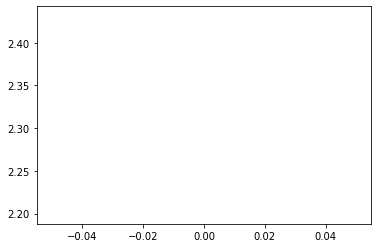

Showing accuracy plot


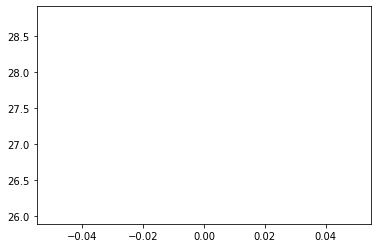

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  3.073160171508789 , Loss  =  1.3049527406692505
Time for batch  8 / 125 =  0.15868544578552246 , Loss  =  1.169211983680725
Time for batch  16 / 125 =  0.09722161293029785 , Loss  =  0.967268705368042
Time for batch  24 / 125 =  0.09937787055969238 , Loss  =  1.5989834070205688
Time for batch  32 / 125 =  0.12376856803894043 , Loss  =  2.7655577659606934
Time for batch  40 / 125 =  0.09622383117675781 , Loss  =  2.354743003845215
Time for batch  48 / 125 =  0.11861610412597656 , Loss  =  0.6991866230964661
Time for batch  56 / 125 =  1.037971019744873 , Loss  =  1.2823336124420166
Time for batch  64 / 125 =  0.1892402172088623 , Loss  =  1.995361328125
Time for batch  72 / 125 =  0.1401064395904541 , Loss  =  1.6197258234024048
Time for batch  80 / 125 =  0.11295676231384277 , Loss  =  2.5804953575134277
Time for batch  88 / 125 =  0.09307432174682617 , Loss  =  2.127650260925293
Time for batch  96 / 125 =  0.09638404846191406 , Loss  =  1.275075912475586
Tim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  1   completed , Avg Loss =  1.6569861469268798  Accuracy =  45.4  TEST Accuracy  31.333333333333332
Showing loss plot


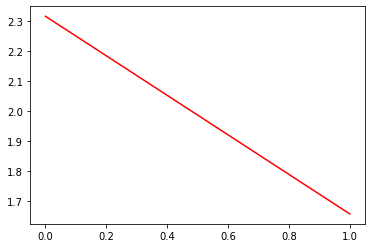

Showing accuracy plot


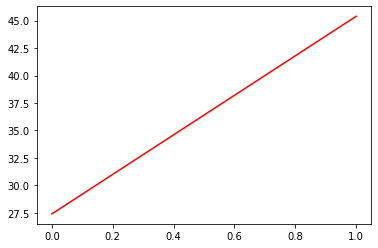

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  3.0224595069885254 , Loss  =  1.146906852722168
Time for batch  8 / 125 =  0.10163402557373047 , Loss  =  0.655877947807312
Time for batch  16 / 125 =  0.09857368469238281 , Loss  =  1.8831634521484375
Time for batch  24 / 125 =  0.10318684577941895 , Loss  =  1.0553098917007446
Time for batch  32 / 125 =  0.12054586410522461 , Loss  =  1.2207181453704834
Time for batch  40 / 125 =  0.11931967735290527 , Loss  =  1.312900424003601
Time for batch  48 / 125 =  0.16855263710021973 , Loss  =  1.2907277345657349
Time for batch  56 / 125 =  0.1009831428527832 , Loss  =  1.6759319305419922
Time for batch  64 / 125 =  0.09697580337524414 , Loss  =  0.908968448638916
Time for batch  72 / 125 =  0.10098481178283691 , Loss  =  1.9359005689620972
Time for batch  80 / 125 =  0.11088871955871582 , Loss  =  1.2016849517822266
Time for batch  88 / 125 =  0.17900872230529785 , Loss  =  0.7228227853775024
Time for batch  96 / 125 =  0.10591650009155273 , Loss  =  2.01583909988

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  2   completed , Avg Loss =  1.1049965834617614  Accuracy =  62.8  TEST Accuracy  48.0
Saving at weights now at step =  2

Saving the latest model  as 'latest_2.pth'.

Showing loss plot


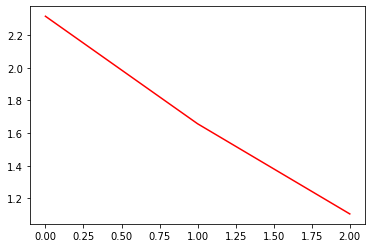

Showing accuracy plot


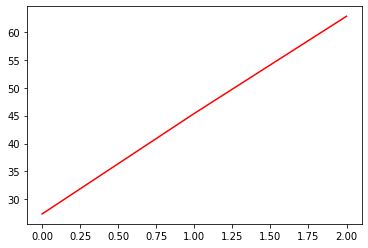

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  3.27933406829834 , Loss  =  0.7181382179260254
Time for batch  8 / 125 =  0.09768819808959961 , Loss  =  0.43079572916030884
Time for batch  16 / 125 =  0.11670064926147461 , Loss  =  0.10580268502235413
Time for batch  24 / 125 =  0.09982156753540039 , Loss  =  0.7874305248260498
Time for batch  32 / 125 =  0.09527373313903809 , Loss  =  0.9693036079406738
Time for batch  40 / 125 =  0.10278892517089844 , Loss  =  0.9473670721054077
Time for batch  48 / 125 =  0.10933065414428711 , Loss  =  0.6963209509849548
Time for batch  56 / 125 =  0.12973999977111816 , Loss  =  0.8415376543998718
Time for batch  64 / 125 =  0.10532879829406738 , Loss  =  1.0667376518249512
Time for batch  72 / 125 =  0.09372591972351074 , Loss  =  0.5800143480300903
Time for batch  80 / 125 =  0.10463476181030273 , Loss  =  0.27893880009651184
Time for batch  88 / 125 =  0.11664128303527832 , Loss  =  0.8032733798027039
Time for batch  96 / 125 =  0.10528802871704102 , Loss  =  0.25024

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  3   completed , Avg Loss =  0.5277517391443253  Accuracy =  83.8  TEST Accuracy  52.0
Saving at weights now at step =  3

Saving the latest model  as 'latest_3.pth'.

Showing loss plot


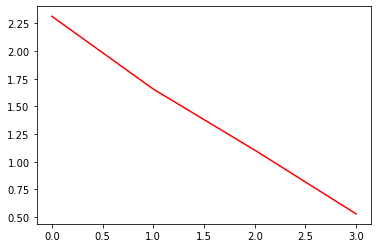

Showing accuracy plot


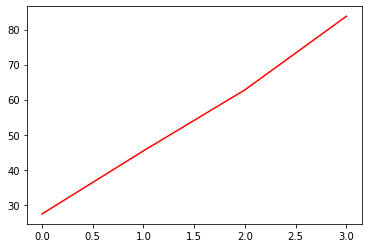

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  3.0835325717926025 , Loss  =  0.1583188772201538
Time for batch  8 / 125 =  0.09711909294128418 , Loss  =  0.14752864837646484
Time for batch  16 / 125 =  0.11011123657226562 , Loss  =  0.0747646614909172
Time for batch  24 / 125 =  0.09985947608947754 , Loss  =  0.2526680827140808
Time for batch  32 / 125 =  0.09639525413513184 , Loss  =  0.1618717908859253
Time for batch  40 / 125 =  0.10206294059753418 , Loss  =  0.05923923850059509
Time for batch  48 / 125 =  0.10824155807495117 , Loss  =  0.12087275087833405
Time for batch  56 / 125 =  0.10010504722595215 , Loss  =  0.11191229522228241
Time for batch  64 / 125 =  0.11535453796386719 , Loss  =  0.6517206430435181
Time for batch  72 / 125 =  0.09944534301757812 , Loss  =  0.06730429083108902
Time for batch  80 / 125 =  0.09864020347595215 , Loss  =  0.17329683899879456
Time for batch  88 / 125 =  0.15322184562683105 , Loss  =  0.039351172745227814
Time for batch  96 / 125 =  0.12860536575317383 , Loss  =  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  4   completed , Avg Loss =  0.1910211194008589  Accuracy =  96.2  TEST Accuracy  52.666666666666664
Saving at weights now at step =  4

Saving the latest model  as 'latest_4.pth'.

Showing loss plot


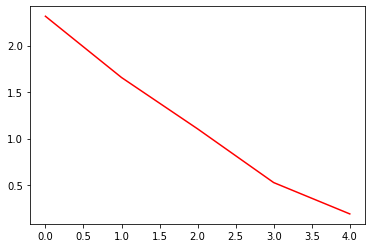

Showing accuracy plot


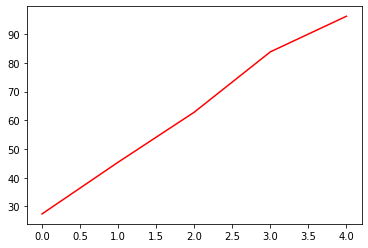

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  3.181124687194824 , Loss  =  0.09361063688993454
Time for batch  8 / 125 =  0.10636639595031738 , Loss  =  0.15548524260520935
Time for batch  16 / 125 =  0.14588332176208496 , Loss  =  0.18560823798179626
Time for batch  24 / 125 =  0.12146210670471191 , Loss  =  0.05198359861969948
Time for batch  32 / 125 =  0.10670709609985352 , Loss  =  0.22309085726737976
Time for batch  40 / 125 =  0.10687065124511719 , Loss  =  0.04486799240112305
Time for batch  48 / 125 =  0.09638547897338867 , Loss  =  0.028113268315792084
Time for batch  56 / 125 =  0.7486288547515869 , Loss  =  0.03967956826090813
Time for batch  64 / 125 =  0.10199856758117676 , Loss  =  0.020480845123529434
Time for batch  72 / 125 =  0.0965268611907959 , Loss  =  0.031140213832259178
Time for batch  80 / 125 =  0.1745588779449463 , Loss  =  0.10281433910131454
Time for batch  88 / 125 =  0.36276960372924805 , Loss  =  0.16710662841796875
Time for batch  96 / 125 =  0.119476318359375 , Loss  = 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  5   completed , Avg Loss =  0.08251728645339608  Accuracy =  98.8  TEST Accuracy  52.666666666666664
Showing loss plot


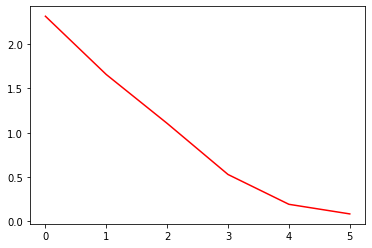

Showing accuracy plot


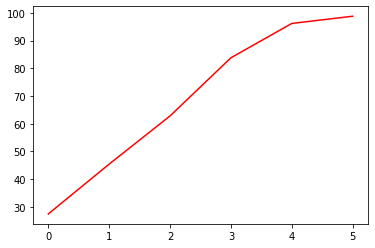

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  2.9823157787323 , Loss  =  0.009022579528391361
Time for batch  8 / 125 =  0.09501457214355469 , Loss  =  0.023608291521668434
Time for batch  16 / 125 =  0.10184741020202637 , Loss  =  0.2925466299057007
Time for batch  24 / 125 =  0.12089967727661133 , Loss  =  0.03752947971224785
Time for batch  32 / 125 =  0.0890047550201416 , Loss  =  0.06957073509693146
Time for batch  40 / 125 =  1.226428747177124 , Loss  =  0.020534101873636246
Time for batch  48 / 125 =  0.1254124641418457 , Loss  =  0.049255840480327606
Time for batch  56 / 125 =  0.10879135131835938 , Loss  =  0.013612786307930946
Time for batch  64 / 125 =  0.09875607490539551 , Loss  =  0.028165994212031364
Time for batch  72 / 125 =  0.10474777221679688 , Loss  =  0.06578804552555084
Time for batch  80 / 125 =  0.10702800750732422 , Loss  =  0.04216349869966507
Time for batch  88 / 125 =  0.14736247062683105 , Loss  =  0.015071864239871502
Time for batch  96 / 125 =  0.10497546195983887 , Loss  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  6   completed , Avg Loss =  0.05057714800909162  Accuracy =  99.5  TEST Accuracy  49.333333333333336
Showing loss plot


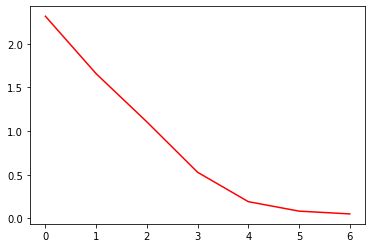

Showing accuracy plot


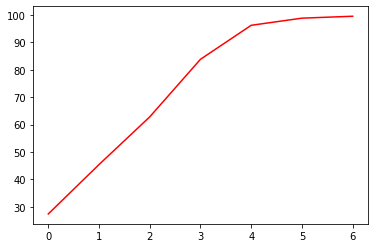

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  2.977372646331787 , Loss  =  0.019937438890337944
Time for batch  8 / 125 =  0.11837983131408691 , Loss  =  0.027853328734636307
Time for batch  16 / 125 =  0.13460803031921387 , Loss  =  0.01636427827179432
Time for batch  24 / 125 =  0.0986778736114502 , Loss  =  0.027096973732113838
Time for batch  32 / 125 =  0.1011042594909668 , Loss  =  0.012838494032621384
Time for batch  40 / 125 =  0.10190105438232422 , Loss  =  0.009511958807706833
Time for batch  48 / 125 =  0.10393786430358887 , Loss  =  0.032612044364213943
Time for batch  56 / 125 =  0.10083818435668945 , Loss  =  0.02005447819828987
Time for batch  64 / 125 =  0.11991453170776367 , Loss  =  0.05224442854523659
Time for batch  72 / 125 =  0.10109543800354004 , Loss  =  0.017344558611512184
Time for batch  80 / 125 =  0.10237908363342285 , Loss  =  0.013238784857094288
Time for batch  88 / 125 =  0.1601700782775879 , Loss  =  0.03363178297877312
Time for batch  96 / 125 =  0.09841394424438477 , L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  7   completed , Avg Loss =  0.02523352388292551  Accuracy =  99.9  TEST Accuracy  54.666666666666664
Saving at weights now at step =  7

Saving the latest model  as 'latest_7.pth'.

Showing loss plot


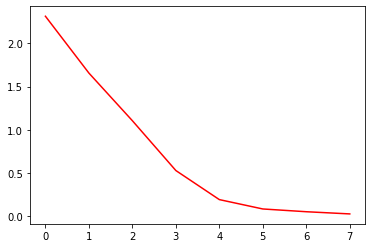

Showing accuracy plot


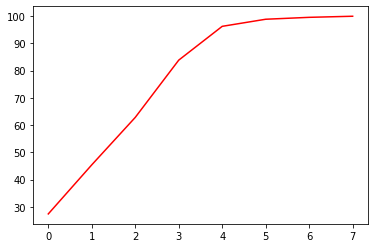

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  3.051947593688965 , Loss  =  0.014533638022840023
Time for batch  8 / 125 =  0.09674668312072754 , Loss  =  0.012762400321662426
Time for batch  16 / 125 =  0.11024165153503418 , Loss  =  0.0049395207315683365
Time for batch  24 / 125 =  0.0960378646850586 , Loss  =  0.004669331945478916
Time for batch  32 / 125 =  0.09883332252502441 , Loss  =  0.014107510447502136
Time for batch  40 / 125 =  0.12403035163879395 , Loss  =  0.005699416622519493
Time for batch  48 / 125 =  0.1058506965637207 , Loss  =  0.004247757606208324
Time for batch  56 / 125 =  0.1008141040802002 , Loss  =  0.005574927665293217
Time for batch  64 / 125 =  0.09937882423400879 , Loss  =  0.008724586106836796
Time for batch  72 / 125 =  0.11606192588806152 , Loss  =  0.013337156735360622
Time for batch  80 / 125 =  0.14811992645263672 , Loss  =  0.007513984572142363
Time for batch  88 / 125 =  0.09940576553344727 , Loss  =  0.0037144909147173166
Time for batch  96 / 125 =  0.107914447784423

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  8   completed , Avg Loss =  0.0194926555454731  Accuracy =  100.0  TEST Accuracy  56.0
Saving at weights now at step =  8

Saving the latest model  as 'latest_8.pth'.

Showing loss plot


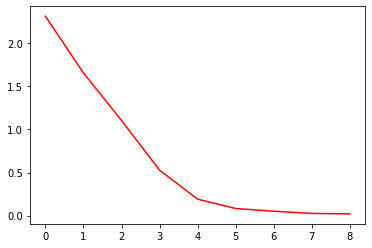

Showing accuracy plot


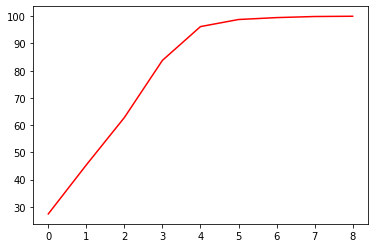

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  3.1083333492279053 , Loss  =  0.007934062741696835
Time for batch  8 / 125 =  0.11003565788269043 , Loss  =  0.009311655536293983
Time for batch  16 / 125 =  0.09799599647521973 , Loss  =  0.021333811804652214
Time for batch  24 / 125 =  0.16186308860778809 , Loss  =  0.003946088720113039
Time for batch  32 / 125 =  0.09658384323120117 , Loss  =  0.010819022543728352
Time for batch  40 / 125 =  0.1212000846862793 , Loss  =  0.005337626673281193
Time for batch  48 / 125 =  0.09608268737792969 , Loss  =  0.03186351805925369
Time for batch  56 / 125 =  0.11293339729309082 , Loss  =  0.014528395608067513
Time for batch  64 / 125 =  0.11451458930969238 , Loss  =  0.015312479808926582
Time for batch  72 / 125 =  0.12797045707702637 , Loss  =  0.010208914056420326
Time for batch  80 / 125 =  0.09673690795898438 , Loss  =  0.02982010506093502
Time for batch  88 / 125 =  0.10556554794311523 , Loss  =  0.017624346539378166
Time for batch  96 / 125 =  0.1034750938415527

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  9   completed , Avg Loss =  0.023387284619733693  Accuracy =  99.6  TEST Accuracy  50.666666666666664
Showing loss plot


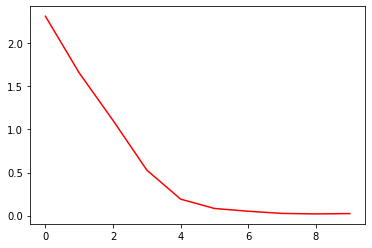

Showing accuracy plot


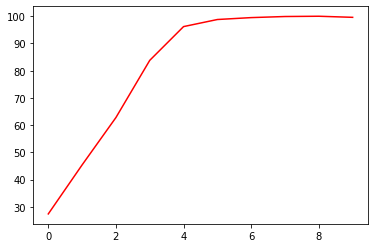

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  2.953333616256714 , Loss  =  0.006341803353279829
Time for batch  8 / 125 =  0.11372780799865723 , Loss  =  0.007599846925586462
Time for batch  16 / 125 =  1.3750700950622559 , Loss  =  0.05951530113816261
Time for batch  24 / 125 =  0.09874176979064941 , Loss  =  0.011005534790456295
Time for batch  32 / 125 =  0.09590029716491699 , Loss  =  0.0030605753418058157
Time for batch  40 / 125 =  0.11775565147399902 , Loss  =  0.01277703046798706
Time for batch  48 / 125 =  0.1043555736541748 , Loss  =  0.011878909543156624
Time for batch  56 / 125 =  0.10301542282104492 , Loss  =  0.020794421434402466
Time for batch  64 / 125 =  0.11797046661376953 , Loss  =  0.0027119475416839123
Time for batch  72 / 125 =  0.11547112464904785 , Loss  =  0.03042689710855484
Time for batch  80 / 125 =  0.09782743453979492 , Loss  =  0.00867043063044548
Time for batch  88 / 125 =  0.10431170463562012 , Loss  =  0.009057240560650826
Time for batch  96 / 125 =  0.15314865112304688 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  10   completed , Avg Loss =  0.012470512129366397  Accuracy =  100.0  TEST Accuracy  54.0
Showing loss plot


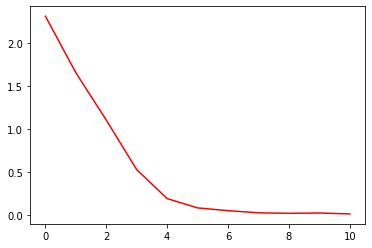

Showing accuracy plot


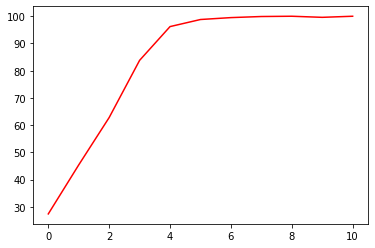

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  2.9689059257507324 , Loss  =  0.005820815917104483
Time for batch  8 / 125 =  0.10228347778320312 , Loss  =  0.01033819280564785
Time for batch  16 / 125 =  0.11745476722717285 , Loss  =  0.0036614565178751945
Time for batch  24 / 125 =  0.10509729385375977 , Loss  =  0.0017962075071409345
Time for batch  32 / 125 =  0.10191226005554199 , Loss  =  0.008290721103549004
Time for batch  40 / 125 =  0.10760664939880371 , Loss  =  0.007328169420361519
Time for batch  48 / 125 =  0.10572409629821777 , Loss  =  0.005337598267942667
Time for batch  56 / 125 =  1.022533655166626 , Loss  =  0.01252400316298008
Time for batch  64 / 125 =  0.17683768272399902 , Loss  =  0.008993291296064854
Time for batch  72 / 125 =  0.1104121208190918 , Loss  =  0.003174468409270048
Time for batch  80 / 125 =  0.09482789039611816 , Loss  =  0.005435283295810223
Time for batch  88 / 125 =  0.11344361305236816 , Loss  =  0.013504721224308014
Time for batch  96 / 125 =  0.0985181331634521

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch no  11   completed , Avg Loss =  0.008190612873993815  Accuracy =  100.0  TEST Accuracy  53.333333333333336
Showing loss plot


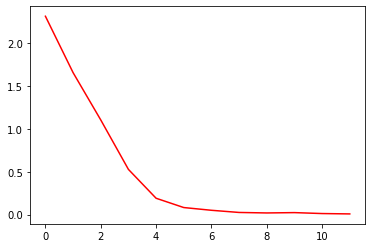

Showing accuracy plot


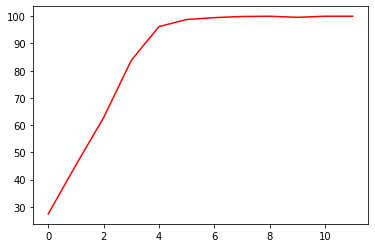

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Time for batch  0 / 125 =  2.9867324829101562 , Loss  =  0.0013656693045049906
Time for batch  8 / 125 =  0.10637474060058594 , Loss  =  0.06278244405984879
Time for batch  16 / 125 =  0.09890913963317871 , Loss  =  0.0029141742270439863
Time for batch  24 / 125 =  0.09495115280151367 , Loss  =  0.005454318132251501
Time for batch  32 / 125 =  0.0970916748046875 , Loss  =  0.015069669112563133
Time for batch  40 / 125 =  0.10739922523498535 , Loss  =  0.002740721218287945
Time for batch  48 / 125 =  0.0962529182434082 , Loss  =  0.016226734966039658
Time for batch  56 / 125 =  0.11546492576599121 , Loss  =  0.0017053376650437713
Time for batch  64 / 125 =  0.12628579139709473 , Loss  =  0.008747237734496593
Time for batch  72 / 125 =  0.10539054870605469 , Loss  =  0.009547589346766472


KeyboardInterrupt: ignored

In [148]:
import torch.backends.cudnn as cudnn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cfg = set_config()

torch.autograd.set_detect_anomaly(True)
net = My_Classifier().to(device)
net.train()
losses = []
accuracies = []

optimizer =optim.SGD(net.parameters(),lr=cfg.lr,momentum=0.9)

###### Load weights if resuming training else initialize 

if cfg.resume:
  wtemp = glob.glob("/content/drive/MyDrive/project_Abhigyan/weights/latest*")
  opttemp = glob.glob("/content/drive/MyDrive/project_Abhigyan/weights/opt*")
  if torch.cuda.is_available():
      net_state_dict = torch.load(wtemp[0])
      optim_state_dict = torch.load(opttemp[0])
  else:
      net_state_dict = torch.load(path, map_location='cpu')
      optim_state_dict = torch.load(path, map_location = 'cpu')
  net.load_state_dict(net_state_dict)
  optimizer.load_state_dict(optim_state_dict)
  start_step = int(wtemp[0].split('.pth')[0].split('_')[-1])+1
  open_file=open(cfg.loss_path +'loss.pkl','rb')
  losses=pickle.load(open_file)
  open_file.close()

  open_file=open(cfg.loss_path +'accuracy.pkl','rb')
  accuracies=pickle.load(open_file)
  open_file.close()

  print(f'\nResume training with \'{start_step}\'.\n')

else:
  
  net.init_weights()
  print(f'\nTraining from begining, weights initialized \n')
  start_step = 0 
  #cfg.resume = True

dataset = vis_cat_dataloader( cfg )
data_loader= DataLoader(dataset,cfg.batch_size,shuffle=True,collate_fn=train_collate)

training = True
time_last = time.time()
step = start_step
L = nn.CrossEntropyLoss()

while training:
  correct = 0
  tot = 0
  avg_loss = 0
  for i,(images,targets) in enumerate(data_loader):
          
    if torch.cuda.is_available():
      images = images.to(device = device , dtype = torch.float ).cuda().detach()
      targets = targets.to(device = device , dtype = torch.long  ).cuda().detach()

    
  ######## Obtain Prediction by passing from model
    pred = net(images)

  ######## Compute cross entrop loss
    loss =  L( pred , targets )

  ######## A step of gradient upadate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    time_this = time.time()
    batch_time = time_this-time_last
    
    avg_loss+= loss.item()

 ########  Counting no. of correct classifications
    _, predicted = pred.max(1)
    tot += targets.size(0)
    correct += predicted.eq(targets).sum().item()

    if i%8==0:
      print("Time for batch " , i , "/", len(data_loader) , "= " , batch_time , ", Loss  = " , loss.item() )
    time_last = time.time()
  
  avg_loss/=len(data_loader)
  accuracy =  100.*correct/tot
  accuracies.append(accuracy)
  losses.append(avg_loss)

  print("Epoch no ",step ,"  completed , Avg Loss = " , avg_loss ,  " Accuracy = " , accuracy  , " TEST Accuracy " , accuracy_test )
 
####### Save weights after epoch and loss history
  
  save_latest(net, optimizer ,  step = step)
  save_loss_acc(losses , accuracies)

  print('Showing loss plot')
  plt.plot(np.array(losses), 'r')
  plt.show()

  print('Showing accuracy plot')
  plt.plot(np.array(accuracies), 'r')
  plt.show()

  step+=1
  if step > cfg.epoch_ul:
    break


TEST FOR BATCH

In [12]:
torch.autograd.set_detect_anomaly(True)
net1 = My_Classifier().to(device)
cfg1 = set_config()
cfg1.mode = "test" 
cfg1.batch_size = 10

###### Load weights  

wtemp = glob.glob("/content/drive/MyDrive/project_Abhigyan/weights/latest*")
if torch.cuda.is_available():
      net_state_dict = torch.load(wtemp[0])
else:
      net_state_dict = torch.load(wtemp[0], map_location='cpu')

net1.load_state_dict(net_state_dict)
net1.eval()


dataset1 = vis_cat_dataloader( cfg1 )
data_loader1= DataLoader(dataset1,cfg1.batch_size,collate_fn= test_collate)

step = 0
L = nn.CrossEntropyLoss()

correct = 0
tot = 0
avg_loss = 0
for i,(images,targets) in enumerate(data_loader1):
  if torch.cuda.is_available():
    images= images.to(device = device , dtype = torch.float ).cuda().detach()
    targets = targets.to(device = device , dtype = torch.long  ).cuda().detach()
  else:
    images = images.to(device = device , dtype = torch.float  ).detach()
    targets = targets.to(device = device , dtype = torch.long).detach()
  ######## Obtain Prediction by passing from model

  pred = net1(images)

  ######## Compute cross entrop loss
  loss =  L( pred , targets )
  avg_loss+= loss.item()


 ########  Counting no. of correct classifications
  _, predicted = pred.max(1)
  t11 = targets.size(0)
  tot+=t11
  t12 =  predicted.eq(targets).sum().item()
  correct += t12

  print("Test batch " , i , "/", len(data_loader1) , " Correct = " , t12 , " Total = ", t11 , " ,  Loss  = " , loss.item() )
  
avg_loss/=len(data_loader1)
accuracy =  100.*correct/tot

print(" Avg Loss = " , avg_loss ,  " Accuracy = " , accuracy )
 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test batch  0 / 15  Correct =  2  Total =  10  ,  Loss  =  2.750926971435547
Test batch  1 / 15  Correct =  4  Total =  10  ,  Loss  =  1.0590659379959106
Test batch  2 / 15  Correct =  8  Total =  10  ,  Loss  =  1.1116572618484497
Test batch  3 / 15  Correct =  3  Total =  10  ,  Loss  =  2.4794301986694336
Test batch  4 / 15  Correct =  7  Total =  10  ,  Loss  =  1.2313709259033203
Test batch  5 / 15  Correct =  5  Total =  10  ,  Loss  =  2.2066407203674316
Test batch  6 / 15  Correct =  4  Total =  10  ,  Loss  =  2.4615867137908936
Test batch  7 / 15  Correct =  4  Total =  10  ,  Loss  =  2.503526210784912
Test batch  8 / 15  Correct =  5  Total =  10  ,  Loss  =  1.705134630203247
Test batch  9 / 15  Correct =  9  Total =  10  ,  Loss  =  0.6419198513031006
Test batch  10 / 15  Correct =  4  Total =  10  ,  Loss  =  1.8037159442901611
Test batch  11 / 15  Correct =  7  Total =  10  ,  Loss  =  1.3918657302856445
Test batch  12 / 15  Correct =  9  Total =  10  ,  Loss  =  0.372